# Longitudinal Pump

The Hamiltonian is
$$
H_\text{long} = \frac{p^2}{2m} + V_\text{ext}(x) - \hbar \Delta_\text{c} a^\dagger a + \hbar \eta (a + a^\dagger) + \hbar U_0 \cos(kx)^2,
$$
where $\Delta_\text{c} = \omega_\text{l} - \omega_\text{c}$, $\eta$ is the pump strength and $U_0$ is the depth of the potential. Note that because $H_\text{long} \propto \cos(kx)^2$, the Hamiltonian is $\lambda / 2$-periodic.

In [1]:
using QuantumOptics, PyPlot, Printf, LinearAlgebra, PyCall

We choose a maximum number of photons of $N_\text{cutoff}=16$. If we choose $k=2\pi$, then $\lambda=1$.

In [2]:
# Define Parameters
N_cutoff = 16
xmin = 0
xmax = 1
Nsteps = 64

k = 2*π
ωr = 1

Δc = -3 * ωr
U0 = -1 * ωr;

In [3]:
# Bases
b_position = PositionBasis(xmin, xmax, Nsteps)
b_fock = FockBasis(N_cutoff)

# Operators for atom
p = momentum(b_position)

# Operators for cavity
a = destroy(b_fock) ⊗ one(b_position)
ad = dagger(a);

In [4]:
# Hamiltonian and calculate states
potential = x -> U0*cos(k*x)^2
H_int = (one(b_fock) ⊗ potentialoperator(b_position, potential))*ad*a
H_kin = (one(b_fock) ⊗ p^2) / k^2
H_cavity = -Δc*ad*a

function H(η)
    H_kin + dense(H_int) + H_cavity + η*(a + ad)
end;

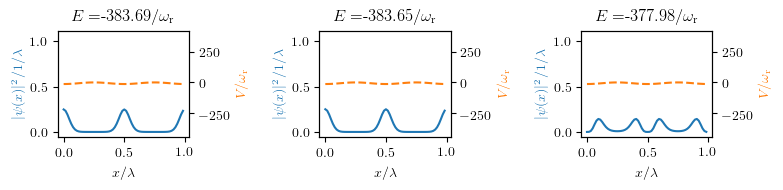

In [5]:
# Plot distributions for first three states

rc("text", usetex=true)
rc("text.latex", preamble= "\\usepackage{amsmath}")
rc("font", family="serif")
pygui(false)

η = 60 * ωr
E, ψ_states = eigenstates((H(η) + dagger(H(η)))/2, 3);

xpoints = samplepoints(b_position)

fig = figure(figsize=(8, 2))
host_1 = fig.add_subplot(131)
host_2 = fig.add_subplot(132)
host_3 = fig.add_subplot(133)
hosts = [host_1, host_2, host_3]

for i in 1:3
    host = hosts[i]
    par1 = host.twinx()
    
    pos_dense = ptrace(ψ_states[i], 1)
    density = diag(pos_dense.data)
    ada_exp = expect(ad*a, ψ_states[i])
    pot = @. U0*cos(k*xpoints)^2*real(ada_exp)
    
    host.set_ylim(-0.0528, 1.1088)
    par1.set_ylim(-441.482335, 415.316547)
#     host.plot(xpoints, abs2.(density ./ sqrt(Nsteps)), "C0")
    host.plot(xpoints, abs2.(normalize(density) ./ sqrt(Nsteps) * 15), "C0")
    par1.plot(xpoints, pot, "C1", linestyle="--")
    
    host.set_xlabel(L"x / \lambda")
    host.set_ylabel(L"|\psi(x)|^2 / 1/\lambda")
    par1.set_ylabel(L"V / \omega_\text{r}")
    host.yaxis.label.set_color("C0")
    par1.yaxis.label.set_color("C1")
    
    # Boundaries
#     println("host.set_ylim(" *@sprintf("%.4f", host.get_ylim()[1]) *", " *@sprintf("%.4f", host.get_ylim()[2]) *")")
#     println("par1.set_ylim(" *@sprintf("%.6f", par1.get_ylim()[1]) *", " *@sprintf("%.6f", par1.get_ylim()[2]) *")")
    
    title(L"E=" * @sprintf("%.2f", E[i]) * L"/ \omega_\text{r}")
end

tight_layout()

Actually, we'd only have to plot from 0 to 0.5 since the Hamiltonian is $\lambda / 2$-periodic. However, we plot form 0 to 1 so that the longitudinal and transversal plots have the same boundaries. We can see that the ground state and the first excited state have the same energy and thus are degenerate states.

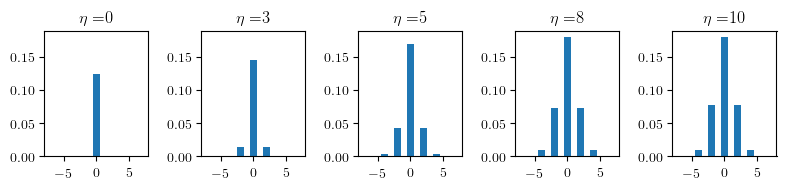

In [6]:
# Plot momentum

rc("text", usetex=true)
rc("font", family="serif")
pygui(false)

b_momentum = MomentumBasis(b_position)
Tpx = transform(b_momentum, b_position)

η_arr = [0, 3, 5, 8, 10] .* ωr

fig = figure(figsize=(8,2))
for i in 1:size(η_arr)[1]
    plt_index = 100 + size(η_arr)[1]*10 + i
    host = fig.add_subplot(plt_index)
#     host.set_xlim(xmin, xmax)
#     host.set_ylim(-0.0001, 0.0017)
    
    E, ψ_states = eigenstates((H(η_arr[i]) + dagger(H(η_arr[i])))/2, 1);
    pos_dense = ptrace(ψ_states[1], 1)
    states_p = Tpx * pos_dense
    density_p = diag(states_p.data)

    host.bar([-Nsteps/2:1:Nsteps/2-1;], abs.(density_p), width=1)
    title_string = L"\eta=" * @sprintf("%d", η_arr[i])
    title(title_string)
    host.set_ylim(0.0000, 0.1893)
    host.set_xlim(-8, 8)
#     println("host.set_ylim(" *@sprintf("%.4f", host.get_ylim()[1]) *", " *@sprintf("%.4f", host.get_ylim()[2]) *")")
    
#     host.set_xlabel(L"x")
#     host.set_ylabel(L"|\psi(x)|^2")
#     host.yaxis.label.set_color("C0")
end
tight_layout()

Between occupied momenta, there's always a gap which is not the case with the transversal pump.

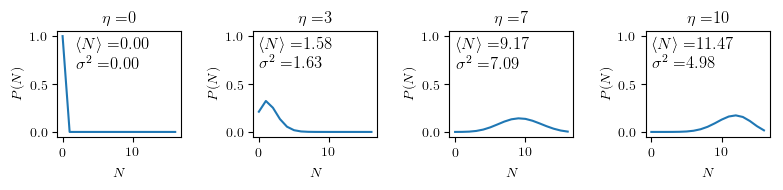

In [12]:
# Plot photon number

rc("text", usetex=true)
rc("font", family="serif")
pygui(false)

η_arr = [0, 3, 7, 10] .* ωr
X = [0:1:N_cutoff;]
displace = [0.15, 0.05, 0.05, 0.05]

fig = figure(figsize=(8,2))
for i in 1:size(η_arr)[1]
    plt_index = 100 + size(η_arr)[1]*10 + i
    host = fig.add_subplot(plt_index)
#     host.set_xlim(xmin, xmax)
#     host.set_ylim(-0.0001, 0.0017)
    
    E, ψ_states = eigenstates((H(η_arr[i]) + dagger(H(η_arr[i])))/2, 1);
    photon_dense = ptrace(ψ_states[1], 2)
    probab = diag(photon_dense.data)

    host.plot(X, probab)
    ada_exp = real(expect(ad*a, ψ_states[1]))
    variance = real(sum(probab .* X.^2) - ada_exp^2)
    
    title_string = L"\eta=" * @sprintf("%d", η_arr[i])
    title(title_string)
    host.set_xlabel(L"N")
    host.set_ylabel(L"P(N)")
    textstr = L"\langle N \rangle=" * @sprintf("%.2f", real(ada_exp)) * "\n" * L"\sigma^2=" * @sprintf("%.2f", variance)
    host.text(displace[i], 0.95, textstr, transform=host.transAxes, fontsize=12, verticalalignment="top")
    
    host.set_ylim(-0.0500, 1.0500)
#     println("host.set_ylim(" *@sprintf("%.4f", host.get_ylim()[1]) *", " *@sprintf("%.4f", host.get_ylim()[2]) *")")
    
end
tight_layout()

Longitudinal and transversal photon number densities are the same.

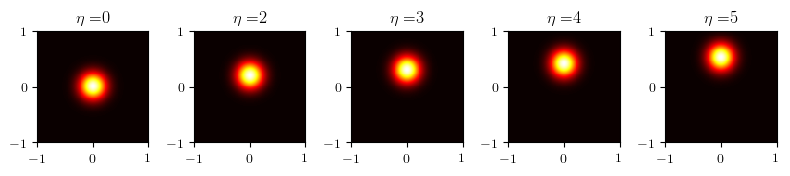

In [8]:
# Qfunc

rc("text", usetex=true)
rc("font", family="serif")
pygui(false)

η_arr = [0, 2, 3, 4, 5] .* ωr

# Boundary
bdr = 6
xvec = [-bdr:.1:bdr;]
yvec = [-bdr:.1:bdr;]

fig = figure(figsize=(8,2))

for i in 1:size(η_arr)[1]
    E, ψ_states = eigenstates((H(η_arr[i]) + dagger(H(η_arr[i]))) / 2, 1);

    plt_index = 100 + size(η_arr)[1] * 10 + i
    subplot(plt_index)
    husimi_q = qfunc(ptrace(ψ_states[1], 2), xvec, yvec)
    imshow(abs.(husimi_q), cmap="hot", interpolation="nearest", extent=(-1,1,-1,1));
    title_string = L"\eta=" * @sprintf("%d", η_arr[i])
    title(title_string)
end

tight_layout();

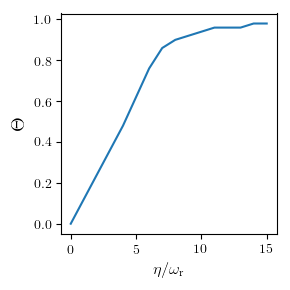

In [9]:
# Plot order parameter
rc("text", usetex=true)
rc("text.latex", preamble= "\\usepackage{amsmath}")
rc("font", family="serif")
pygui(false)

η_arr = [0:1:15;] .* ωr
bdr = 7
step = 0.1
xvec = [-bdr:step:bdr;]
yvec = [-bdr:step:bdr;]

order_param_arr = []
for i in 1:size(η_arr)[1]
    E, ψ_states = eigenstates((H(η_arr[i]) + dagger(H(η_arr[i]))) / 2, 1);
    husimi_q = qfunc(ptrace(ψ_states[1], 2), xvec, yvec)
    husimi_q_sub = husimi_q[1:trunc(Int, bdr/step+1),:]
    temp = abs(findmax(abs.(husimi_q_sub))[2][1] - (bdr/step+1)) / 50
    push!(order_param_arr, temp)
end

figure(figsize=(3,3))
plot(η_arr, order_param_arr)
xlabel(L"\eta / \omega_\text{r}", fontsize=12)
ylabel(L"\Theta", fontsize=14)
# title("Order parameter longitudinal");
tight_layout()

As opposed to the transversal pump, there's no critical pump strength at which the order parameter rises quickly.